# Modeling Attack on Arbiter PUFs

#### Ryan King
#### Hardware and System Security
#### 2024

<br>
    Physical Unclonable Functions (PUF) are pieces of hardware used for hardware authentication. PUFs are designed to give deterministic “random” results from a set of inputs, called a challenge. If we are able to predict a PUFs response to any challenge, then we have compromised the PUF, because someone else can accurately predict and correctly respond to new challenges, thus breaking confidentiality.

<br>

## Exploration into data

<br>
Before we begin, we need to analyze and understand the nature of our data.
<br>

#### Data - Modeling APUFs

<br>
    Recall that an arbiter PUF (APUF) relies on the inherent delay of multiplexers, by building two paths of cross-coupled multiplexers. The APUF then gives an output based on which path responds first. In such a way, the APUF theoretically provides a unique reliable and random response given a challenge that can be used for identification and authentication of hardware. 
<br>   

#### Simulation Method

<br> 
    We are utilizing pypuf to simulate Arbiter PUFs.Pypuf utilizes the additive delay model to model arbiter PUFs, which has been shown to be an accurate representation of Arbiter PUF behavior (ACM, 2002). In this model, we assume that the delays encountered by a signal as it traverses different paths within the PUF are additive. In other words, the total delay experienced by a signal can be calculated by summing up the delays along each path.
<br>

#### Approach to attacking APUF
However, because of this additive delay nature of the APUF, we can assume that each bit of the challenge (which controls the data path via multiplexer) affects the speed of each line of data in a linear fashion. Thus, it may be possible to predict responses to unseen challenges using linear decision machine learning models. This is a modeling attack that can break the integrity of an APUF.

<br>

# Preface to Preprocessing

Commercial PUFs like the n-xpuf on an Artix®-7 FPGAs180 using the Xilinx Vivado design suite utilize 256 bit challenges. Typically, we represent this as 16 hexadecimal digit challenges, such as chal = 4BB5F64640B18CCF. Our response is either 0 or 1, but here, we will represent challenge and response bits as either [-1, 1]. 

In [66]:
import matplotlib.pyplot as plt #This is used for plotting
import numpy as np #This is used to provide multidimensional array objects

import pandas as pd #Tool for data analysis and manipulation.
from pypuf.simulation import ArbiterPUF #Pypuf is used to simulate PUFs
from pypuf.io import random_inputs
import pypuf.metrics
import pypuf.attack
import pypuf.io

from IPython.display import display
import matplotlib.pyplot as plt #Graphing

PUFs are intrinsically designed to be difficult to predict, because it relies on process variation in manufacturing, and has many inputs in its challenge. PUF responses can be affected by noise, environmental disturbances, and process variations. Because of this, we will introduce noise to account for this challenge.

In [7]:
hexadecimal_digit_challenge = 16 #Represents number of hexadecimal digits used in challenge. Typically, this is a power of 2.
num_param = hexadecimal_digit_challenge * 16

puf = ArbiterPUF(n=num_param, noisiness = 0.05, seed=1) #0.05 noise

Using our simulated puf, we can evaluate responses from a given challenge, like so.

In [19]:
test_value = random_inputs(n=num_param, N=1, seed=2)

print(f"Given test challenge {test_value[0]}:")

print(f"response: {puf.eval(test_value)[0]}")

print(f"Puf average reliability: {pypuf.metrics.reliability(puf, seed=3).mean()}")

Given test challenge [-1 -1  1  1  1 -1  1  1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1
  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1  1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1  1  1  1  1 -1  1 -1
  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1
  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1 -1
 -1  1 -1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1
 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1
 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1  1]:
response: -1
Puf average reliability: 0.9794020761245674


First, let us create a random sample of 10000 challenge response pairs

In [21]:
number_samples = 10000
r_i = random_inputs(n = num_param, N = number_samples, seed = 2)
x = pd.DataFrame(r_i) #Challenges
y = puf.eval(r_i) #Responses

crp = pypuf.io.ChallengeResponseSet(x, y) #Generate challenge response objects

del r_i #Free memory, because r_i is an extremely large array.

#### Mathematical Assumptions

<br>
We model our PUF response as response = sign(noise + w,x⟩), where N is noise represented by gaussian distribution with a magnitude of our noisiness value chosen earlier, x is our feature vector (Challenge), and W are our weights. Our assumption that our challenges and responses are -1 and 1 come in play here, as it makes our gaussian distribution's mean 0 and variance of our noise.

<br> From the assumption that our noise can be modeled as a gaussian distribution, we can calculate our error function as E[r(x)]=erf(⟨w,x⟩2–√σnoise), and with basic algebraic manipulation, we can find ⟨w,x⟩=2–√σnoise⋅erf−1E[r(x)].

We can utilize least squares regression, which works by minimizing the sum of the squared differences of observed and predicted values to predict our weights, which will serve as our model

In [25]:


attack = pypuf.attack.LeastSquaresRegression(crp, feature_map=lambda 
cs: ArbiterPUF.transform_atf(cs, k=1)[:, 0, :])#Creating linear mapping for x from nonlinear challenge. 
model = attack.fit()#Training the model

print(f"Accuracy: {pypuf.metrics.similarity(puf, model, seed=4)[0]}")

Accuracy: 0.0


We can see that our accuracy is currently 0. Let's test a sample value to see what might be happening.

In [26]:
model.eval(test_value)

array([[-1.05645845]])

Recall earlier that when evaluating our PUF simulation with this same test value, our response was -1. Because -1.0564 doesn't exactly match with -1, we fail. We need to apply a postprocessing pass to set values to either -1 or 1 using a threshold of 0.

In [27]:
model.postprocessing = model.postprocessing_threshold
model.eval(test_value)

array([[-1.]])

There we go! After post processing, let's check our accuracy again.

In [28]:
print(f"Accuracy: {pypuf.metrics.similarity(puf, model, seed=4)[0]}")

Accuracy: 0.961


### Success!
Nice! We can see that our accuracy is quite high, at 96%.
However, given real world conditions, we may not have the liberty of testing 10 thousand challenge response pairs, as shown 

In [73]:
def attack_puf(noise, samples, parameters):
    rand_inp = random_inputs(n = parameters, N = samples, seed = 2)
    puf1 = ArbiterPUF(n=parameters, noisiness = noise, seed=1) #0.05 noise
    x1 = pd.DataFrame(rand_inp) #Challenges
    y1 = puf1.eval(rand_inp) #Responses
    del rand_inp
    crp1 = pypuf.io.ChallengeResponseSet(x1, y1)
    attack1 = pypuf.attack.LeastSquaresRegression(crp1, feature_map=lambda cs: ArbiterPUF.transform_atf(cs, k=1)[:, 0, :])#Creating linear mapping for x from nonlinear challenge. 
    model1 = attack1.fit()
    model1.postprocessing = model1.postprocessing_threshold
    return pypuf.metrics.similarity(puf1, model1, seed=4)[0]

def attack_puf_seed(noise, samples, parameters, seed):
    rand_inp = random_inputs(n = parameters, N = samples, seed = seed)
    puf1 = ArbiterPUF(n=parameters, noisiness = noise, seed=seed) #0.05 noise
    x1 = pd.DataFrame(rand_inp) #Challenges
    y1 = puf1.eval(rand_inp) #Responses
    del rand_inp
    crp1 = pypuf.io.ChallengeResponseSet(x1, y1)
    attack1 = pypuf.attack.LeastSquaresRegression(crp1, feature_map=lambda cs: ArbiterPUF.transform_atf(cs, k=1)[:, 0, :])#Creating linear mapping for x from nonlinear challenge. 
    model1 = attack1.fit()
    model1.postprocessing = model1.postprocessing_threshold
    return pypuf.metrics.similarity(puf1, model1, seed=seed)[0]

def average_accuracy(noise, samples, parameters, n):
    accuracy = 0
    for i in range(n):
        accuracy += attack_puf_seed(noise, samples, parameters, i)
    accuracy/=n
    return accuracy

average_accuracy(0.1, 1000, 256, 5)

0.9359999999999999

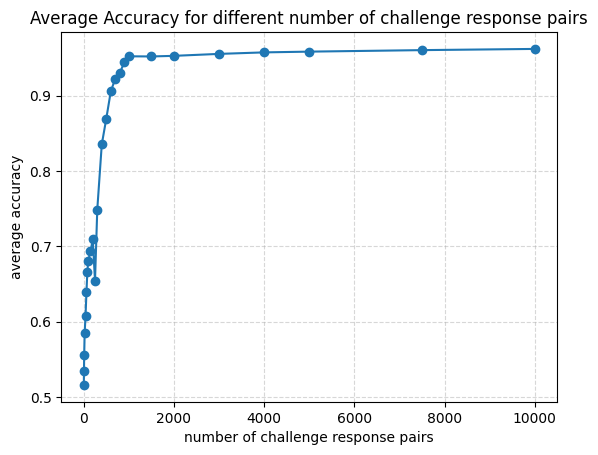

In [75]:
k_vals = [2,5,10,20,40,60,80,100,150,200,250,300,400,500,600,700,800,900,1000,1500,2000,3000,4000,5000, 7500, 10000]
accuracy_store = []
for i in k_vals:
    accuracy_store.append(average_accuracy(0.05, i, 256, 5))
plt.plot(k_vals,accuracy_store, marker='o')
plt.xlabel('number of challenge response pairs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('average accuracy')
plt.title('Average Accuracy for different number of challenge response pairs')
plt.show()

[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0, 1.05, 1.1, 1.1500000000000001, 1.2000000000000002, 1.25, 1.3, 1.35, 1.4000000000000001, 1.4500000000000002, 1.5, 1.55, 1.6, 1.6500000000000001, 1.7000000000000002, 1.75, 1.8, 1.85, 1.9000000000000001, 1.9500000000000002]


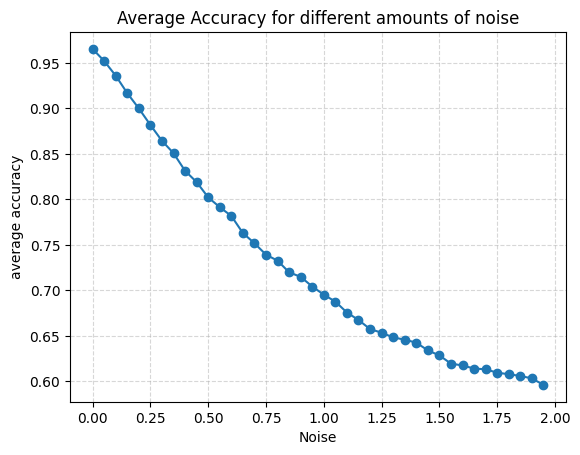

In [82]:
k_vals = np.arange(0, 2.0, 0.05).tolist()
print(k_vals)
accuracy_store = []
for i in k_vals:
    accuracy_store.append(average_accuracy(i, 1000, 256, 5))
plt.plot(k_vals,accuracy_store, marker='o')
plt.xlabel('Noise')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('average accuracy')
plt.title('Average Accuracy for different amounts of noise')
plt.show()

Citations

Gassend, B., Clarke, D., van Dijk, M. & Devadas, S. Silicon Physical Random Functions. in Proceedings of the 9th ACM Conference on Computer and Communications Security 148–160 (ACM, 2002)

Y. Fang, C. Wang, Q. Ma, C. Gu, M. O’Neill and W. Liu, "Attacking Arbiter PUFs Using Various Modeling Attack Algorithms: A Comparative Study," 2018 IEEE Asia Pacific Conference on Circuits and Systems (APCCAS), Chengdu, China, 2018

Mursi, Khalid T., Yu Zhuang, Mohammed Saeed Alkatheiri, and Ahmad O. Aseeri. "Extensive
Examination of XOR Arbiter PUFs as Security Primitives for Resource-Constrained IoT Devices." In
2019 17th International Conference on Privacy, Security and Trust (PST), pp. 1-9. IEEE, 2019